Исследование болезни сердце.

This heart disease dataset is curated by combining 5 popular heart disease datasets already available independently but not combined before. In this dataset, 5 heart datasets are combined over 11 common features which makes it the largest heart disease dataset available so far for research purposes. The five datasets used for its curation are:

Cleveland
Hungarian
Switzerland
Long Beach VA
Statlog (Heart) Data Set.
This dataset consists of 1190 instances with 11 features. These datasets were collected and combined at one place to help advance research on CAD-related machine learning and data mining algorithms, and hopefully to ultimately advance clinical diagnosis and early treatment.

## Загрузка данных

In [27]:
import pandas as pd
import  numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import (OneHotEncoder, 
                                     OrdinalEncoder, 
                                     StandardScaler, 
                                     MinMaxScaler, 
                                     RobustScaler,
                                     PolynomialFeatures)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings

from scipy.spatial.distance import cityblock 
import sklearn.metrics.pairwise

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif  
import shap
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier



In [28]:
def analysis(df, step:int):
    if step==1:
        for i in df.select_dtypes(include='object').columns:
            print('-----',i,'-----')
            print(df[i].value_counts())
            print()
            pie(df[i].value_counts(), i);
    if step==2:        
        for i in df.select_dtypes(exclude='object').columns:
            print('------',i,'---------')
            print(df[i].describe())
            print()
            boxhist(data=df, x=i, title=i);
            
def pie(df,title):
    colors = sns.color_palette("light:#5A9")
    df.plot(kind='pie',autopct='%1.1f%%',
                                      figsize=(5,5),colors=colors,shadow=True,
                                      title = title);
    plt.show()         
def boxhist(data, x, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.boxplot(ax=axes[0],data=data, x=x,palette="crest");
    axes[0].set_xlabel(title)
    axes[0].set_title(title)


    sns.histplot(ax=axes[1],data=data, x=x, kde=True, palette="crest");
    axes[1].set_title(title);
    axes[1].set_xlabel(title)
    axes[1].axvline(data[x].mean(), c='k', ls='-', lw=2.5)
    axes[1].axvline(data[x].median(), c='orange', ls='--', lw=2.5)
    plt.xlabel(title);
    plt.show()

In [29]:
data = pd.read_csv('C://Users/Serg//practicum/database/heart_statlog_cleveland_hungary_final.csv')

In [30]:
data.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


## Предобработка данных

In [32]:
data=data.rename(columns={'chest pain type':'chest_pain_type','resting bp s':'resting_bp_s',
                          'fasting blood sugar':'fasting_blood_sugar','resting ecg':'resting_ecg',
                                    'max heart rate':'max_heart_rate','exercise angina':'exercise_angina',
                                   'ST slope':'ST_slope'})

In [33]:
data.isna().sum()

age                    0
sex                    0
chest_pain_type        0
resting_bp_s           0
cholesterol            0
fasting_blood_sugar    0
resting_ecg            0
max_heart_rate         0
exercise_angina        0
oldpeak                0
ST_slope               0
target                 0
dtype: int64

In [34]:
data.duplicated().sum()

272

In [35]:
data[['sex','chest_pain_type','fasting_blood_sugar',
     'resting_ecg','exercise_angina','ST_slope','target']]=data[['sex','chest_pain_type','fasting_blood_sugar',
     'resting_ecg','exercise_angina','ST_slope','target']].astype('object')

Присутствуют дубликаты. Пропусков нет.

##  Исследовательский анализ данных

In [36]:
analysis(data, step=1)

Мужчин в датасете преоблодающее количество 76%.
У 52% ангина бессимптомная стенокардия.
у 23% боль не связаная с стенокардия.
у 78% пациентов уровень сахара в крови меньше 120mg/dl.


------ age ---------
count    1190.000000
mean       53.720168
std         9.358203
min        28.000000
25%        47.000000
50%        54.000000
75%        60.000000
max        77.000000
Name: age, dtype: float64



Ignoring `palette` because no `hue` variable has been assigned.


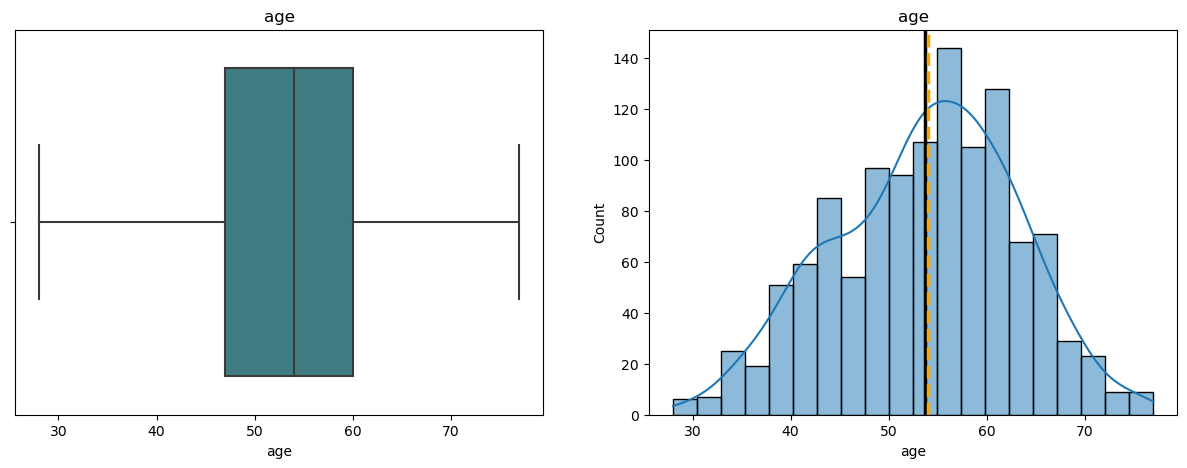

------ sex ---------
count    1190.000000
mean        0.763866
std         0.424884
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: sex, dtype: float64



Ignoring `palette` because no `hue` variable has been assigned.


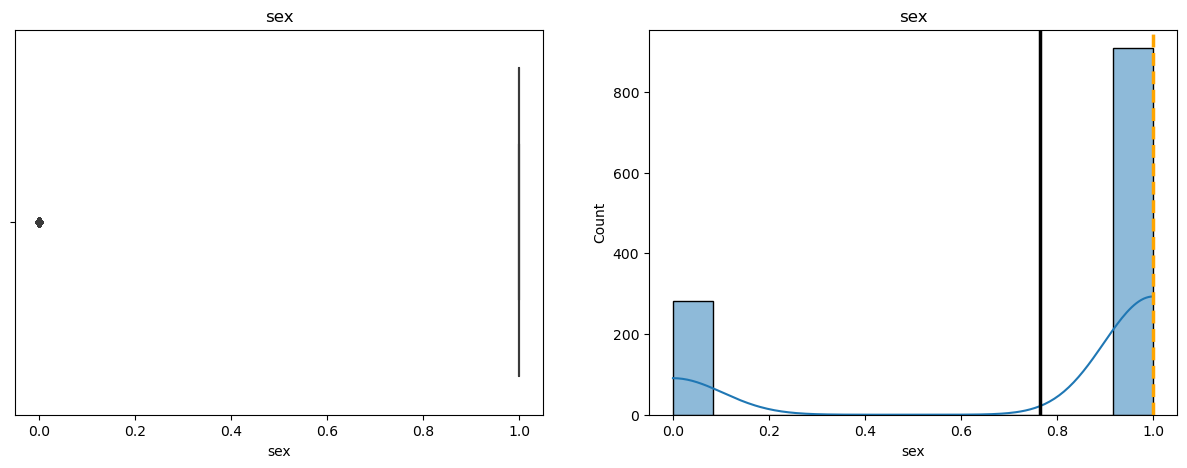

------ chest_pain_type ---------
count    1190.000000
mean        3.232773
std         0.935480
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: chest_pain_type, dtype: float64



Ignoring `palette` because no `hue` variable has been assigned.


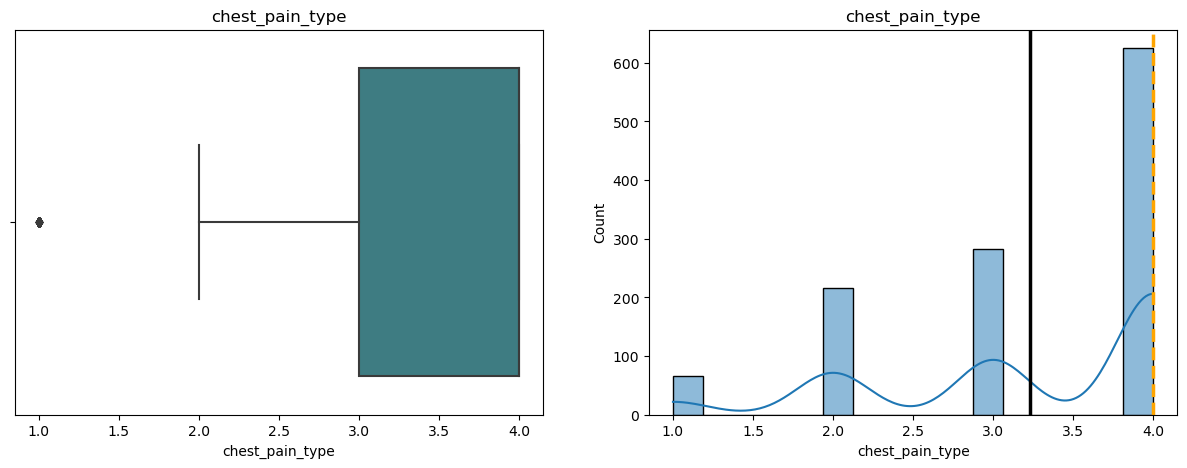

------ resting_bp_s ---------
count    1190.000000
mean      132.153782
std        18.368823
min         0.000000
25%       120.000000
50%       130.000000
75%       140.000000
max       200.000000
Name: resting_bp_s, dtype: float64



Ignoring `palette` because no `hue` variable has been assigned.


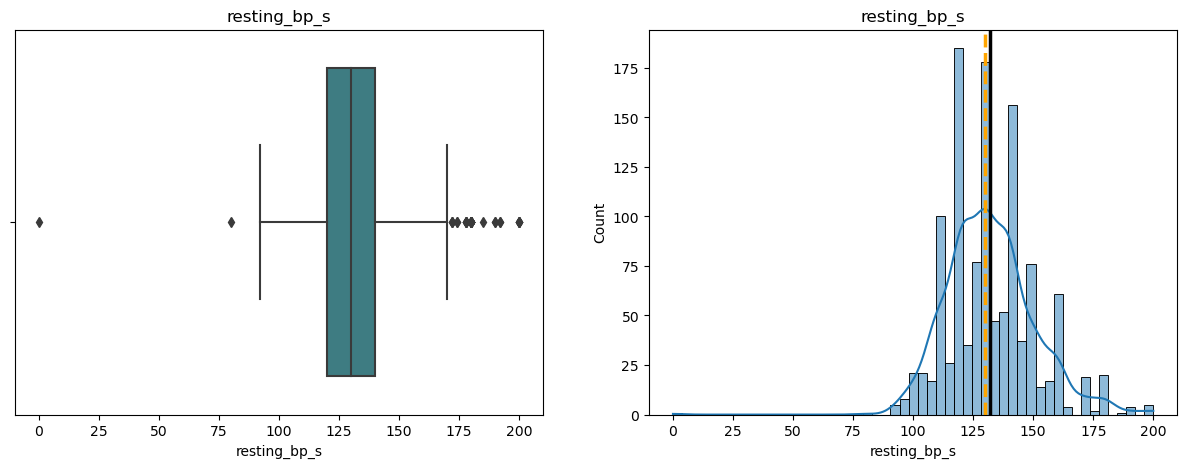

------ cholesterol ---------
count    1190.000000
mean      210.363866
std       101.420489
min         0.000000
25%       188.000000
50%       229.000000
75%       269.750000
max       603.000000
Name: cholesterol, dtype: float64



Ignoring `palette` because no `hue` variable has been assigned.


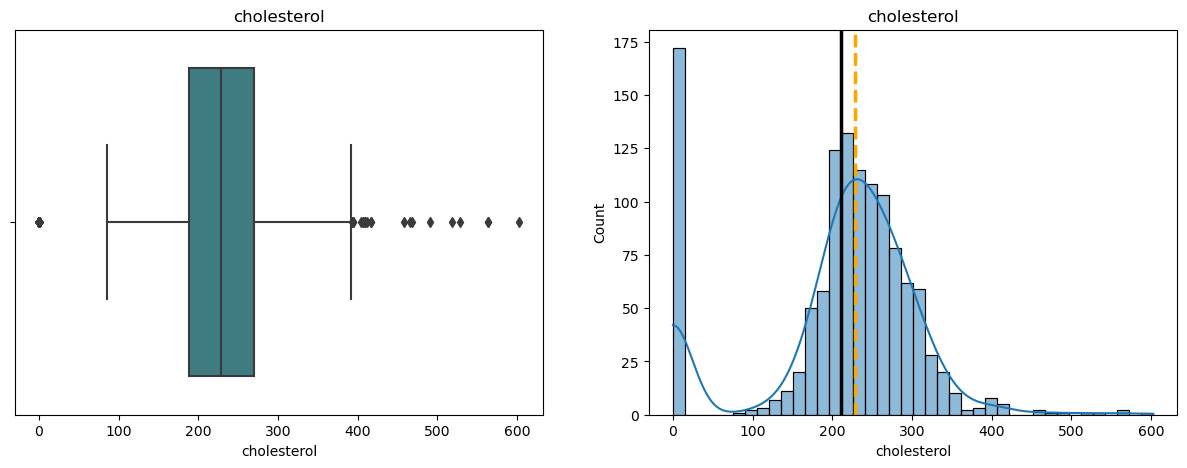

------ fasting_blood_sugar ---------
count    1190.000000
mean        0.213445
std         0.409912
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: fasting_blood_sugar, dtype: float64



Ignoring `palette` because no `hue` variable has been assigned.


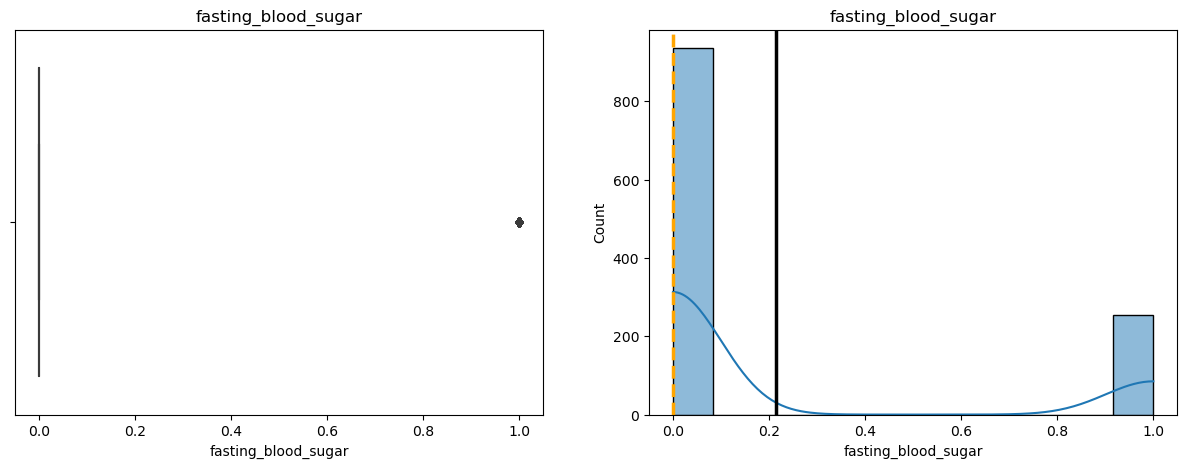

------ resting_ecg ---------
count    1190.000000
mean        0.698319
std         0.870359
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max         2.000000
Name: resting_ecg, dtype: float64



Ignoring `palette` because no `hue` variable has been assigned.


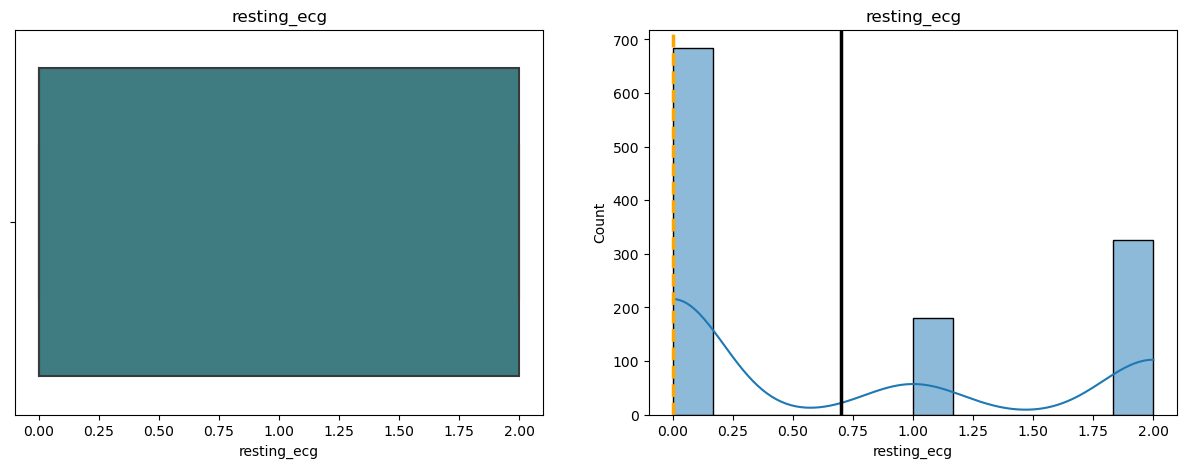

------ max_heart_rate ---------
count    1190.000000
mean      139.732773
std        25.517636
min        60.000000
25%       121.000000
50%       140.500000
75%       160.000000
max       202.000000
Name: max_heart_rate, dtype: float64



Ignoring `palette` because no `hue` variable has been assigned.


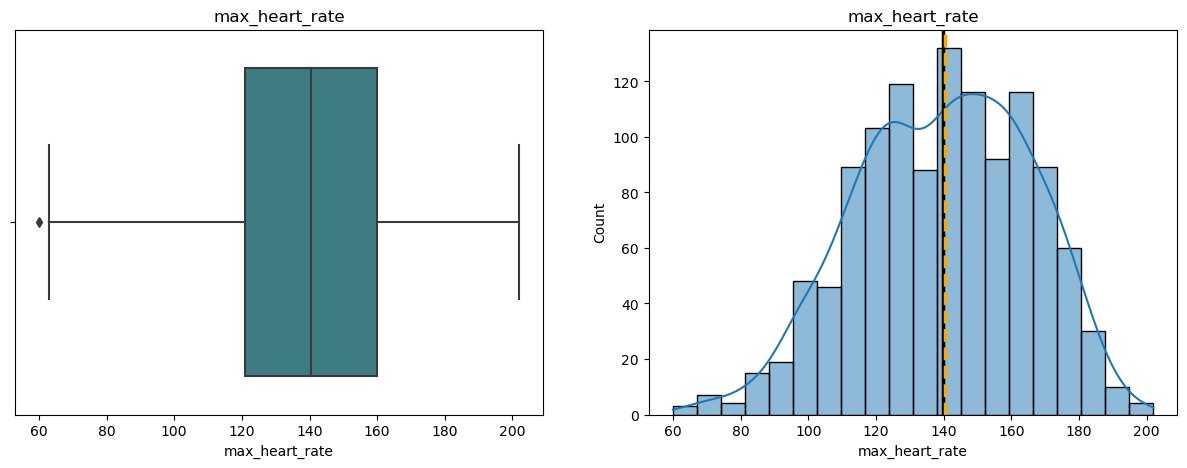

------ exercise_angina ---------
count    1190.000000
mean        0.387395
std         0.487360
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: exercise_angina, dtype: float64



Ignoring `palette` because no `hue` variable has been assigned.


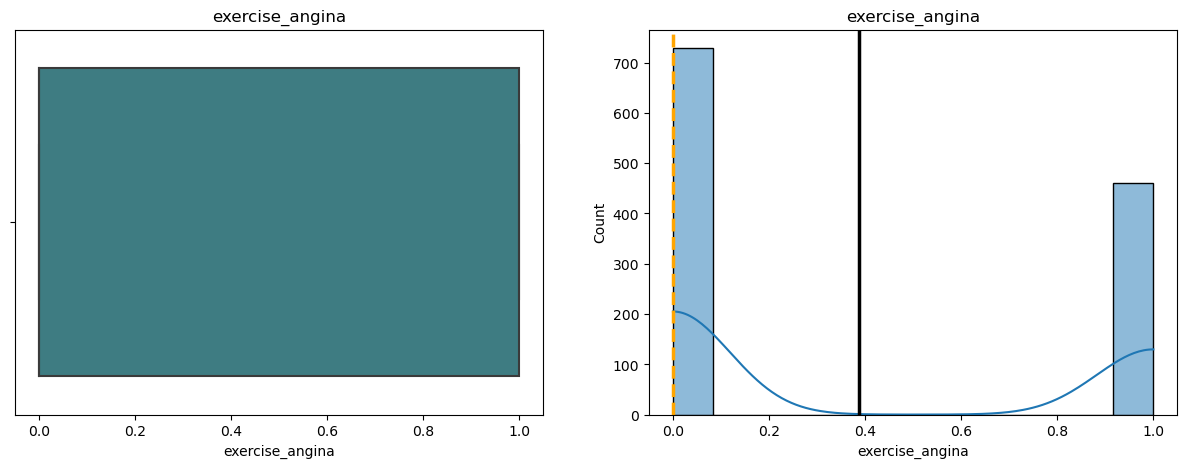

------ oldpeak ---------
count    1190.000000
mean        0.922773
std         1.086337
min        -2.600000
25%         0.000000
50%         0.600000
75%         1.600000
max         6.200000
Name: oldpeak, dtype: float64



Ignoring `palette` because no `hue` variable has been assigned.


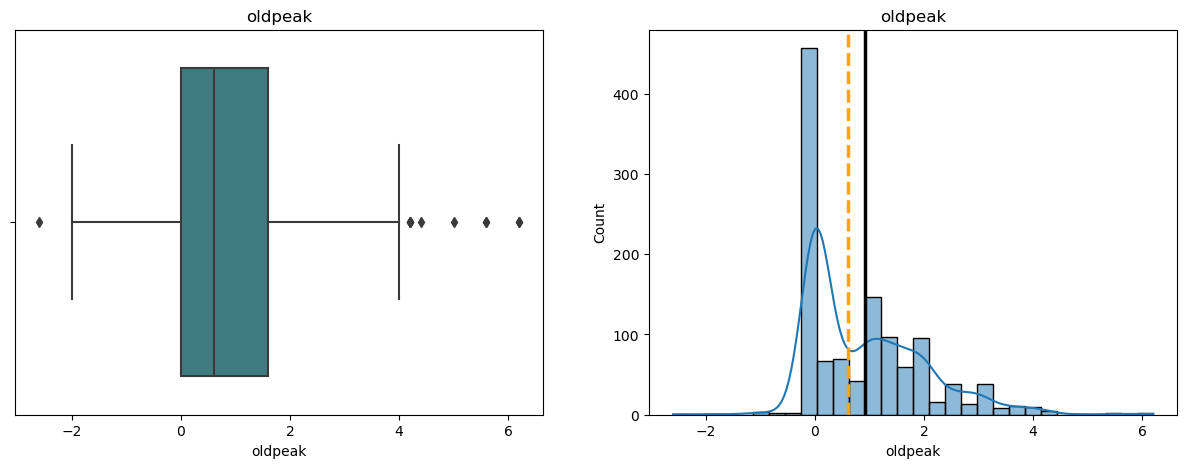

------ ST_slope ---------
count    1190.000000
mean        1.624370
std         0.610459
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: ST_slope, dtype: float64



Ignoring `palette` because no `hue` variable has been assigned.


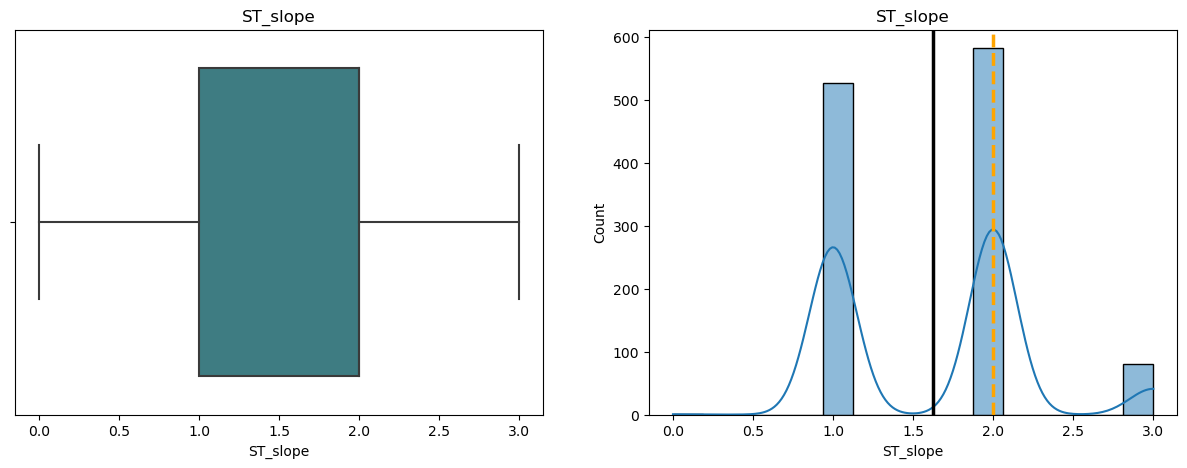

------ target ---------
count    1190.000000
mean        0.528571
std         0.499393
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64



Ignoring `palette` because no `hue` variable has been assigned.


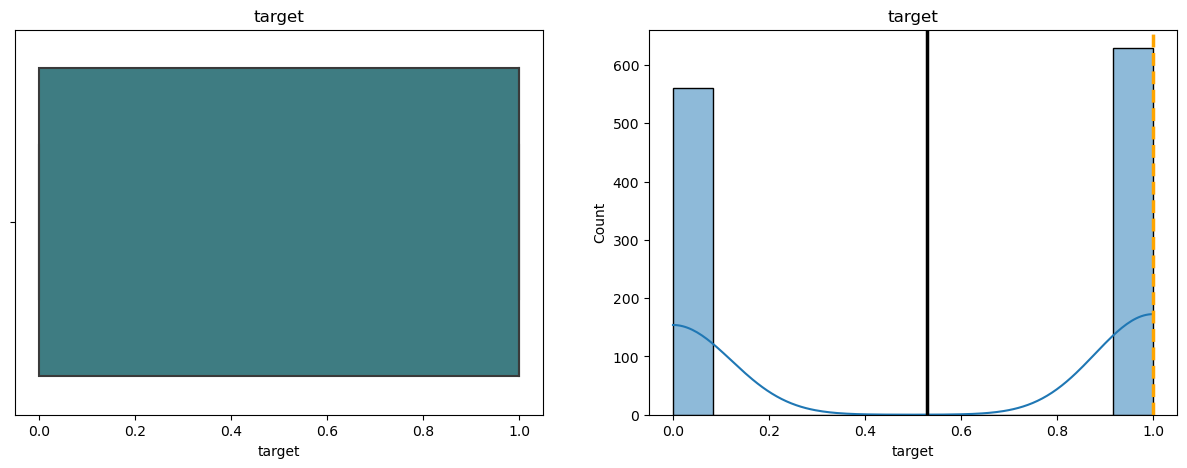

In [37]:
analysis(data, step=2)

### Корреляционный анализ

In [38]:
cf = data.phik_matrix(interval_cols=['age', 'resting_bp_s', 'cholesterol', 'max_heart_rate', 'oldpeak']) 
cf.style.background_gradient(cmap='Blues')

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,ST_slope,target
age,1.000000,0.000000,0.250949,0.218784,0.203522,0.222851,0.264571,0.426588,0.234113,0.311827,0.256240,0.354876
sex,0.000000,1.000000,0.265845,0.000000,0.303306,0.163643,0.039666,0.271214,0.294390,0.167559,0.187078,0.465225
chest_pain_type,0.250949,0.265845,1.000000,0.120560,0.199296,0.175179,0.103138,0.363116,0.628558,0.332240,0.510102,0.735126
resting_bp_s,0.218784,0.000000,0.120560,1.000000,0.120785,0.099781,0.116384,0.174470,0.116943,0.118213,0.115271,0.130937
cholesterol,0.203522,0.303306,0.199296,0.120785,1.000000,0.399222,0.313800,0.355679,0.141941,0.187494,0.145051,0.406449
fasting_blood_sugar,0.222851,0.163643,0.175179,0.099781,0.399222,1.000000,0.073474,0.117391,0.065792,0.188771,0.233115,0.328023
resting_ecg,0.264571,0.039666,0.103138,0.116384,0.313800,0.073474,1.000000,0.261200,0.062931,0.189438,0.063674,0.070377
max_heart_rate,0.426588,0.271214,0.363116,0.174470,0.355679,0.117391,0.261200,1.000000,0.538306,0.343228,0.369530,0.538118
exercise_angina,0.234113,0.294390,0.628558,0.116943,0.141941,0.065792,0.062931,0.538306,1.000000,0.554961,0.605778,0.683475
oldpeak,0.311827,0.167559,0.332240,0.118213,0.187494,0.188771,0.189438,0.343228,0.554961,1.000000,0.539456,0.562246


## машинное обучение


In [13]:
RS=42
le = LabelEncoder()

X = data.drop(['target'],axis=1)
y = data['target']

y = le.fit_transform(y)

X_train, X_test,y_train, y_test = train_test_split(X,y,random_state=RS)

In [14]:
col_num = list(X_train.select_dtypes(exclude='object').columns)
col_ohe = ['sex','exercise_angina','ST_slope']
col_ord = ['chest_pain_type','fasting_blood_sugar','resting_ecg']
col_cat = list(X_train.select_dtypes(include='object').columns)

In [15]:
pipe_ohe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))])
pipe_ord = ord_pipe = Pipeline([
    
    ('ord',  OrdinalEncoder(categories=[[4,3,2,1],[0,1],[0,1,2]],
        handle_unknown='use_encoded_value',unknown_value=-1))])

In [16]:
preprocessor = ColumnTransformer(
    [
    ('ohe', pipe_ohe, col_ohe),
    ('ord', pipe_ord, col_ord),
    ('num', StandardScaler(), col_num)
    ], 
    remainder='passthrough') 

In [17]:
pipe_final = Pipeline(
    [('preprocessor', preprocessor),
    ('models', DecisionTreeClassifier(random_state=RS))]) 

In [18]:
def RSCV(estimator, parametrs):
    return GridSearchCV(
    estimator, 
    parametrs, 
    cv=5,
    scoring='accuracy',
    error_score='raise',
    n_jobs=-1
)

In [19]:
param_dtc =[{
        'models__max_depth': range(3,16),
        'models__min_samples_leaf': range(1,7),
       # 'models__max_features': range(2,11),
        'models__min_samples_split': range(2,10)
}]

In [39]:
random_dtc =  RSCV(pipe_final,param_dtc)
random_dtc.fit(X_train, y_train)

model_dtc = random_dtc.best_estimator_

print ('Метрика acc на тренировочной выборке:', random_dtc.best_score_)

Метрика acc на тренировочной выборке: 0.8554014186177892


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [21]:
param_cat =[{
     'models__max_depth': range(5,16)
}]
pip_cat = Pipeline([
   # [('preprocessor', preprocessor),
    ('models',CatBoostClassifier(cat_features=col_cat,
                                 auto_class_weights='Balanced',
                                 verbose=100,
                                 random_state=RS))])

In [22]:
random_cat =  RSCV(pip_cat,param_cat)
random_cat.fit(X_train, y_train)
model_cat = random_cat.best_estimator_

print ('Метрика acc на тренировочной выборке:', random_cat.best_score_)

Learning rate set to 0.009812
0:	learn: 0.6841453	total: 167ms	remaining: 2m 46s
100:	learn: 0.3166900	total: 2.79s	remaining: 24.8s
200:	learn: 0.2044899	total: 5.41s	remaining: 21.5s
300:	learn: 0.1528948	total: 8.1s	remaining: 18.8s
400:	learn: 0.1242341	total: 10.7s	remaining: 16s
500:	learn: 0.1027938	total: 13.3s	remaining: 13.2s
600:	learn: 0.0855212	total: 15.9s	remaining: 10.5s
700:	learn: 0.0711303	total: 18.5s	remaining: 7.91s
800:	learn: 0.0583030	total: 21.3s	remaining: 5.29s
900:	learn: 0.0477880	total: 24.2s	remaining: 2.66s
999:	learn: 0.0396898	total: 27.1s	remaining: 0us
Метрика acc на тренировочной выборке: 0.8934969556211161


In [40]:
preprocessor_lr = ColumnTransformer(
    [
    ('ohe', pipe_ohe, col_cat),
    ('num', StandardScaler(), col_num)
    ], 
    remainder='passthrough') 
param_lr =[{
     
}]
pip_lr = Pipeline(
    [('preprocessor', preprocessor_lr),
    ('models',LogisticRegression(random_state=RS))])

In [41]:
random_lr =  RSCV(pip_lr,param_lr)
random_lr.fit(X_train, y_train)
model_lr = random_lr.best_estimator_

print ('Метрика acc на тренировочной выборке:', random_lr.best_score_)

Метрика acc на тренировочной выборке: 0.8228297030945955


In [25]:
# проверка на адекватность
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train,y_train)
accuracy_score(y_test,dummy_clf.predict(X_test))

0.5671140939597316

In [26]:
accuracy_score(y_test,model_cat.predict(X_test))

0.9261744966442953

## Вывод

Были загружены и исследованы данные о заболеваниях сердца:
- названия столбцов приведены к стандарту
- были проверены на пропуски и дубликаты
- некоторые признаки были приведены к типу `object`
Были обучены 3 модели машинного обучения:
-DecisionTreeClassifier, acc=0.85
- CatBoost, acc= 0.89
- LogisticRegression acc=0.83

Самая высокая метрика у CatBoost её и использовали для предсказания на тестовых данных
- проверка на адекватность пройдена
- метрика тестовых данных: 0.9
